# TD2 part 2: Named entity recognition

Dans ce TD, nous allons prendre un datasets où les noms de personnes sont taggés.<br>
Nous allons transformer ces données en tenseurs X, y et attention_mask.<br>
Nous allons créer un modèle RNN pour prédire si un mot est un nom de personne.<br>
Nous allons ensuite créer la loop avec l'optimizer pour apprendre le modèle.<br>
Du modèle appris (prédisant sur les tokens), nous allons postprocess les prédictions pour avoir les prédictions sur les noms.

Un fois que la loop est créée et que le modèle apprend, nous allons changer la structure du modèle:
- Changer learning rate. Comment se comporte le modèle
- Ajouter des couches denses, ReLU, dropout, normalization
- Changer le nombre de layers du RNN, LSTM.

Lorsqu'on a un bon modèle de prédiction pour les noms de personnes, nous allons l'appliquer à notre projet fil rouge.
Utilisez-le tel que. Quelle accuracy ?
Ré-entrainez la (les) dernière(s) couche(s) du modèle sur notre jeu de données. A-t-il gagné en accuracy ?

In [1]:
# Import
import matplotlib.pyplot as plt
import numpy as np
import torch
import transformers

## Data

Télécharger le dataset MultiNERD FR [ici](https://github.com/Babelscape/multinerd)<br>
Mettez les données dans le dossier data/raw du projet.


In [2]:
def extract_multinerd_person_words(filename="../data/raw/train_fr.tsv"):
    with open(filename, encoding='utf-8') as f:
        tagged_words = [line.strip().split("\t") for line in f]
        
        # Joining words until we meet a dot
        # Word's label is 1 if 'PER' is in its tag
        sentences = []
        sentence_labels = []
    
        this_word = []
        this_labels = []
        for tagged_word in tagged_words:
            if len(tagged_word) < 3:
                # not a tagged word
                continue
            word = tagged_word[1]
            tag = tagged_word[2]
        
            if word == '.':
                sentences.append(" ".join(this_word))
                sentence_labels.append(this_labels)
            
                this_word = []
                this_labels = []
            else:
                this_word.append(word)
                this_labels.append(1 * tag.endswith("PER"))

    return sentences, sentence_labels


In [3]:
sentences, labels = extract_multinerd_person_words()

## Tokenizer

En utilisant le tokenizer d'HuggingFace "camembert-base":
- Transformer les phrases en tokens
- Obtenez des vecteur y qui ont le même nombre d'entrées qu'il y a de tokens dans la phrase
- Ayez un tenseur "attention_mask" pour savoir sur quels tokens on cherche à predire le label
- Transformez les tokens en token_ids (avec le tokenizer)
Avec tout cela, vous pouvez former vos tenseurs X, Y et attention_mask

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("camembert-base")

In [5]:
def build_tokens_and_labels_and_attention_mask(tokenizer, sentence, labels):
    words = sentence.split()
    tokens = []
    tokens_label = []
    attention_mask = []
    
    for word, label in zip(words, labels):
        this_tokens = tokenizer.tokenize(word)
        tokens += this_tokens
        
        this_labels = [0] * len(this_tokens)
        this_labels[0] = label        
        tokens_label += this_labels
        
        this_attention_mask = [1] + [0] * (len(this_tokens) - 1)
        attention_mask += this_attention_mask
        
    # Convertir les tokens en token_ids
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
        
    return tokens, token_ids, tokens_label, attention_mask

In [6]:
tokens, token_ids, label, padding_masks = build_tokens_and_labels_and_attention_mask(tokenizer, sentences[0], labels[0])

In [7]:
from tqdm import tqdm

def build_tensors(sentences, labels, tokenizer, max_len):
    X = []
    y = []
    attention_masks = []

    for sentence, label in tqdm(zip(sentences, labels), total=len(sentences), desc="Processing sentences"):
        tokens, token_ids, label_ids, attention_mask = build_tokens_and_labels_and_attention_mask(tokenizer, sentence, label)

        # Padding
        padding_length = max_len - len(token_ids)
        token_ids.extend([0] * padding_length)
        label_ids.extend([0] * padding_length)
        attention_mask.extend([0] * padding_length)

        X.append(token_ids)
        y.append(label_ids)
        attention_masks.append(attention_mask)

    return torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long), torch.tensor(attention_masks, dtype=torch.long)


In [8]:
max_len = max([len(tokenizer.encode(sentence)) for sentence in sentences])
X, y, attention_mask = build_tensors(sentences, labels, tokenizer, max_len)

Processing sentences: 100%|██████████| 140436/140436 [00:47<00:00, 2983.17it/s]


## Model

Contruisez un modèle RNN comme dans la partie 1. Pour l'instant, il prendra comme arguments:
- Vocab size: le nombre de différents tokens du tokenizer (52 000 pour camembert-base)
- Embedding dim: la dimension de l'embedding des tokens (par défaut 50)
- hidden_dim: la dimension de l'état récurrent de votre RNN (par défaut 20)
- tagset_size: la nombre de classes possibles pour les prédictions (ici 2)

Dans le forward, votre modèle enchaînera les couches suivantes:
- Un embedding
- Un RNN
- Un ReLU
- Une couche linéaire
- Un softmax pour que la somme des prédictions pour une entrée soit égale à 1 (la prédiction pour un élément et sa probabilité d'être dans chaque classe)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim=20, tagset_size=2):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim

        # Couches du modèle
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_dim, tagset_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sentence):
        embeds = self.embedding(sentence)  # Transforme chaque token ID en un vecteur d'embedding
        rnn_out, _ = self.rnn(embeds)      # Passe les embeddings au RNN
        rnn_out = rnn_out.view(-1, self.hidden_dim)  # Redimensionne la sortie pour la couche linéaire
        linear_out = self.linear(rnn_out)
        softmax_out = self.softmax(linear_out)
        return softmax_out
    
class RNNModelModified(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim=20, tagset_size=2):
        super(RNNModelModified, self).__init__()
        self.hidden_dim = hidden_dim

        # Couches du modèle
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=2)
        self.dropout = nn.Dropout(p=0.5)  # Ajout d'une couche dropout
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)  # Ajout d'une couche linéaire supplémentaire
        self.linear2 = nn.Linear(hidden_dim, tagset_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, sentence):
        embeds = self.embedding(sentence)
        rnn_out, _ = self.rnn(embeds)
        rnn_out = self.dropout(rnn_out)
        rnn_out = rnn_out.view(-1, self.hidden_dim)
        linear_out = self.relu(self.linear1(rnn_out))
        linear_out = self.linear2(linear_out)
        softmax_out = self.softmax(linear_out)
        return softmax_out

In [10]:

# Paramètres du modèle
vocab_size = 52000  # Nombre de tokens différents dans CamemBERT
embedding_dim = 50  # Dimension de l'embedding
hidden_dim = 20     # Dimension de l'état récurrent du RNN
tagset_size = 2     # Nombre de classes possibles (ici 2, pour nom ou pas nom)

# Création du modèle
# model = RNNModel(vocab_size, embedding_dim, hidden_dim, tagset_size)
model_modified = RNNModelModified(vocab_size, embedding_dim, hidden_dim, tagset_size)

## Optimizer

Je fournis ici une fonction prenant un modèle, des tenseurs X, y, attention_mask.
Pour chaque batch:
- La loop utilise le modèle pour prédire sur x_batch
- Avec attention_mask, elle identifie sur quels tokens les prédictions compte
- Elle regarde la cross entropy entre y\[attention_ids\] et yhat\[attention_ids\]
- Elle output un dictionnaire avec le model et la loss au fur et à mesure des itérations

Entraînez le modèle avec vos données. <br>
Plottez la loss history.<br>
Itérez sur le modèle pour l'améliorer:
- Changer learning rate. Comment se comporte le modèle
- Ajouter des couches denses, ReLU, dropout, normalization
- Changer le nombre de layers du RNN, LSTM.



In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, loader, device):
    model.eval()  # Met le modèle en mode évaluation
    model.to(device)
    true_labels = []
    predictions = []

    with torch.no_grad():  # Pas de calcul de gradient nécessaire
        for x_batch, y_batch, mask in loader:
            x_batch, y_batch, mask = x_batch.to(device), y_batch.to(device), mask.to(device)
            yhat = model(x_batch)
            yhat = yhat.view(-1, 2)
            ids = mask.view(-1) == 1
            this_y = y_batch.view(-1)[ids]
            yhat = yhat[ids]

            predicted_labels = torch.max(yhat, 1)[1]  # Obtient l'indice de la classe la plus probable
            true_labels.extend(this_y.cpu().numpy())
            predictions.extend(predicted_labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='binary')
    recall = recall_score(true_labels, predictions, average='binary')
    f1 = f1_score(true_labels, predictions, average='binary')

    return accuracy, precision, recall, f1

In [12]:

def train_model(model, X, y, attention_masks, n_epochs=100, lr=0.05, batch_size=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  # Move model to the appropriate device
    loss_function = torch.nn.CrossEntropyLoss()
    loss_history = []
    metrics_history = {"accuracy": [], "precision": [], "recall": [], "f1": []}

    dataset = torch.utils.data.TensorDataset(X, y, attention_masks)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        model.train()  # Met le modèle en mode d'entraînement
        epoch_loss = 0.0
        with tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch + 1}/{n_epochs}") as t:
            for i, (x_batch, y_batch, mask) in t:
                
                x_batch, y_batch, mask = x_batch.to(device), y_batch.to(device), mask.to(device)  # Move batch data to the appropriate device
                
                optimizer.zero_grad()
            
                yhat = model(x_batch)
                yhat = yhat.view(-1, 2)

                ids = mask.view(-1) == 1
                this_y = y_batch.view(-1)[ids]
                yhat = yhat[ids]

                loss = loss_function(yhat, this_y)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                t.set_postfix(loss=epoch_loss / (i + 1))

        loss_history.append(epoch_loss / len(loader))
        
        # Évaluation du modèle
        accuracy, precision, recall, f1 = evaluate_model(model, loader, "cuda" if torch.cuda.is_available() else "cpu")
        metrics_history["accuracy"].append(accuracy)
        metrics_history["precision"].append(precision)
        metrics_history["recall"].append(recall)
        metrics_history["f1"].append(f1)

        print(f"Epoch {epoch + 1}, Average Loss: {loss_history[-1]}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}")
    
    return {"model": model, "loss_history": loss_history, "metrics_history": metrics_history}

Epoch 1/3: 100%|██████████| 1098/1098 [00:04<00:00, 228.52it/s, loss=0.0819]


Epoch 1, Average Loss: 0.08191044334125432, Accuracy: 0.9759901254749695, Precision: 0.7134932453678708, Recall: 0.7999148602177716, F1: 0.7542365440337166


Epoch 2/3: 100%|██████████| 1098/1098 [00:04<00:00, 242.00it/s, loss=0.0562]


Epoch 2, Average Loss: 0.056233776465248325, Accuracy: 0.9767903320826786, Precision: 0.7477889337045577, Recall: 0.7485449744248076, F1: 0.7481667630653449


Epoch 3/3: 100%|██████████| 1098/1098 [00:04<00:00, 239.68it/s, loss=0.0552]


Epoch 3, Average Loss: 0.055180988293175054, Accuracy: 0.9767943147342484, Precision: 0.8007968127490039, Recall: 0.6604585575458458, F1: 0.7238886762534856


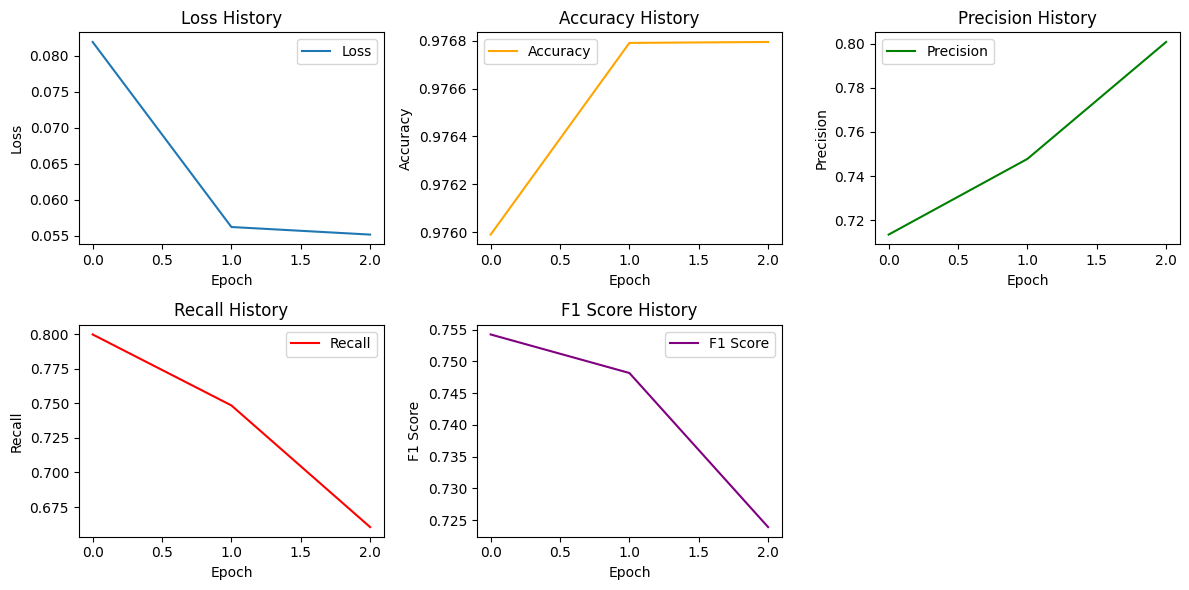

In [13]:
# Entraînement du modèle
results = train_model(model_modified, X, y, attention_mask, n_epochs=3, lr=0.01, batch_size=128)

# Récupération de l'historique de la perte et des métriques
loss_history = results["loss_history"]
metrics_history = results["metrics_history"]

# Visualisation de la perte
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.plot(loss_history, label='Loss')
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Visualisation de l'accuracy
plt.subplot(2, 3, 2)
plt.plot(metrics_history["accuracy"], label='Accuracy', color='orange')
plt.title("Accuracy History")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Visualisation de la precision
plt.subplot(2, 3, 3)
plt.plot(metrics_history["precision"], label='Precision', color='green')
plt.title("Precision History")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend()

# Visualisation du recall
plt.subplot(2, 3, 4)
plt.plot(metrics_history["recall"], label='Recall', color='red')
plt.title("Recall History")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()

# Visualisation du F1 Score
plt.subplot(2, 3, 5)
plt.plot(metrics_history["f1"], label='F1 Score', color='purple')
plt.title("F1 Score History")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
torch.save(model_modified.state_dict(), "model/model_p2.pt")

## Postprocessing

Créer une fonction prenant les prédictions du modèle (au niveau token) et sort les prédictions au niveau mot.<br>
Par exemple, admettons que, pour un mot, la prédiction du 1er token est la seule qu'on considère.<br>
si la phrase est "Bonjour John", avec les tokens \["bon", "jour", "Jo", "hn"\] avec les predictions \[0.12, 0.65, 0.88, 0.45\]<br>
Je veux récupérer les prédictions "bonjour": 0.12, "John": 0.88

In [15]:
model_loaded = RNNModelModified(vocab_size, embedding_dim, hidden_dim, tagset_size)


In [16]:
phrase = "Bonjour Jhon, que pense tu de Alice?"
inputs = tokenizer(phrase, return_tensors="pt", padding=True, truncation=True, max_length=max_len)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_loaded = model_loaded.to(device)  # Move model to the appropriate device
model_loaded.load_state_dict(torch.load("model/model_p2.pt"))
model_loaded.eval()  # Mettre le modèle en mode évaluation

inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model_loaded(inputs['input_ids'])
    predictions = torch.argmax(outputs, dim=-1)

if predictions.ndim > 1:
    token_predictions = predictions[0].tolist()
else:
    token_predictions = predictions.tolist()

print("Tokens:", tokens)
print("Predictions:", token_predictions)

Tokens: ['▁Il', '▁est', '▁incarné', '▁par', '▁A', 'ustin', '▁S', 'to', 'well']
Predictions: [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]


In [17]:

def postprocess_predictions(tokens, preds):
    word_predictions = {}
    current_word = ""
    current_pred = None

    for token, pred in zip(tokens, preds):
        if token.startswith("▁"):  # Un nouveau mot commence
            if current_word and current_pred is not None:
                word_predictions[current_word] = current_pred
            current_word = token[1:]
            current_pred = pred
        elif token in ["</s>", "<s>"]:  # Ignore les tokens spéciaux
            continue
        else:
            current_word += token

    if current_word and current_pred is not None:  # Ajoute la prédiction du dernier mot
        word_predictions[current_word] = current_pred

    return word_predictions

In [18]:
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
word_preds = postprocess_predictions(tokens, token_predictions)
print("Word Predictions:", word_preds)

Word Predictions: {'Bonjour': 0, 'Jhon,': 1, 'que': 0, 'pense': 0, 'tu': 0, 'de': 0, 'Alice?': 1}
